In [2]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from time import time

### Dataseti Sınıflarına Ayırıyorum
Dataset Link: http://tdface.ece.tufts.edu/downloads/TD_RGB_E/

In [ ]:
main_path = "C:/Users/Asus/Desktop/AIATUS/dataset/"
target_path1 = "C:/Users/Asus/Desktop/AIATUS/LastDataset/Neutral/"
target_path2 = "C:/Users/Asus/Desktop/AIATUS/LastDataset/Smile/"
target_path3 = "C:/Users/Asus/Desktop/AIATUS/LastDataset/Eye Closed/"
target_path4 = "C:/Users/Asus/Desktop/AIATUS/LastDataset/Shocked/"
target_path5 = "C:/Users/Asus/Desktop/AIATUS/LastDataset/Sunglass/"


for klasor in os.listdir(main_path):
    print(klasor)
    image_path = main_path+klasor
    for i, filename in enumerate(os.listdir(image_path)):
        print(filename)
        image = Image.open(os.path.join(image_path,filename))
        try:
            if filename == "TD_RGB_E_1.jpg":
                image.save(target_path1 +str(klasor)+str(filename)+str(i) + ".jpg")
            if filename == "TD_RGB_E_2.jpg":
                image.save(target_path2 +str(klasor)+str(filename)+str(i) + ".jpg")
            if filename == "TD_RGB_E_3.jpg":
                image.save(target_path3 +str(klasor)+str(filename)+str(i) + ".jpg")
            if filename == "TD_RGB_E_4.jpg":
                image.save(target_path4 +str(klasor)+str(filename)+str(i) + ".jpg")
            if filename == "TD_RGB_E_5.jpg":
                image.save(target_path5 +str(klasor)+str(filename)+str(i) + ".jpg")
        except:
            print("Error.")
            
print("Tamamlandı.")

### Parameters

In [20]:
lr=0.001
epoch_count=15
train_ratio=0.9
train_batch_size=5
validation_batch_size=5
test_batch_size=5
num_classes=5

### Data sayısı az olduğu için pre-trained RESNET kullanarak transfer learning yapıyorum. Data az olduğu için test seti feda ettim.

In [26]:
model = models.resnet50(pretrained=True)

#TRANSFER LEARNING*****************************
for isim, param in model.named_parameters():
    
    if 'layer4' not in isim:
        param.requires_grad = False

model.fc = torch.nn.Linear(2048, num_classes) 
#**********************************************

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resnet girişi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

#loading and spliting data**********************
dataset = datasets.ImageFolder('./LastDataset', transform = train_transforms)
    
print("Class and Label Ids:",dataset.class_to_idx)
dataset_size = len(dataset)
train_set_size = int(dataset_size * train_ratio)
validation_set_size = dataset_size-train_set_size

    
print("Training set size:", train_set_size)
print("Validation set size:", validation_set_size)

    
    
train_set, validation_set= torch.utils.data.random_split(dataset, [train_set_size, validation_set_size])
    
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle=True, drop_last=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = validation_batch_size, shuffle=True, drop_last=True)
    

    
train_loader = [batch for batch in train_loader]
train_batch_count = len(train_loader)
print("Traning Set Batch Count:",train_batch_count)
print("Training Set Batch Size:",train_batch_size)
   
validation_loader = [batch for batch in validation_loader]
validation_batch_count = len(validation_loader)
print("Validation Set Batch Count:",validation_batch_count)
print("Validation Set Batch Size:",validation_batch_size)

Class and Label Ids: {'Eye Closed': 0, 'Neutral': 1, 'Shocked': 2, 'Smile': 3, 'Sunglass': 4}
Training set size: 504
Validation set size: 57
Traning Set Batch Count: 100
Training Set Batch Size: 5
Validation Set Batch Count: 11
Validation Set Batch Size: 5


### Visualize the Image

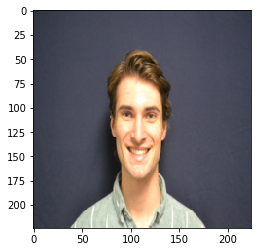

In [22]:
batch_id = 12
data_id = 3
x = train_loader[batch_id][0][data_id]
z = x * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
z = z + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img = transforms.ToPILImage(mode='RGB')(z)
plt.imshow(img)

### Training

In [27]:
training_loss_list = []
validation_loss_list = []
training_accuracy_list = []
validation_accuracy_list = []
train_error_list = []
validation_error_list = []

    
    
def TrueCount(pred, y_true, epoch, batch_id, set_type):
    true_count = 0
    for i in range(pred.size(0)):
        if torch.argmax(pred[i]).item()==y_true[i].item():
            true_count += 1

        else:#yanlış tahmin yaptıysa ve son epochta ise:
            if epoch==epoch_count-1:
                vector = [batch_id, i, torch.argmax(pred[i]).item(), y_true[i].item()]
                if set_type == "train":
                    train_error_list.append(vector)
                if set_type == "validation":
                    validation_error_list.append(vector)
                if set_type == "test":
                    test_error_list.append(vector)
    return true_count    
    
    
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
t = time()
    
for epoch in range(epoch_count):
        
    training_loss = 0
    toplam = 0
    dogru = 0
        
    for batch_id in range(len(train_loader)):
        X,y = train_loader[batch_id]
        #multi-label

        model.train()
        optimizer.zero_grad()
        cikti = model(X)
        loss = criterion(cikti, torch.tensor(y, dtype=torch.long))
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

            
        #Evaluation
        with torch.no_grad():
            model.eval()
            cikti = model(X)
            dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"train")
            toplam = toplam + y.size(0)
                
    training_accuracy = (dogru/toplam)*100
    training_loss = training_loss/train_batch_count
    training_loss_list.append(training_loss)  
    training_accuracy_list.append(training_accuracy)
    print("Epoch {} | Training Loss: {} | Training Accuracy: {}%".format(epoch,training_loss,str(training_accuracy)))  
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************     
        
        
    validation_loss = 0
    toplam = 0
    dogru = 0                    
    for batch_id in range(len(validation_loader)): 
        X,y = validation_loader[batch_id]
        with torch.no_grad():
            model.eval()
            cikti = model(X)
            loss = criterion(cikti, torch.tensor(y, dtype=torch.long))
            validation_loss += loss.item() 
            dogru = dogru + TrueCount(cikti,y,epoch,batch_id,"validation")
            toplam = toplam + y.size(0)
                
    validation_accuracy = (dogru/toplam)*100
    validation_loss = validation_loss/validation_batch_count
    validation_loss_list.append(validation_loss)  
    validation_accuracy_list.append(validation_accuracy)
    print("Epoch {} | Validation Loss: {} | Validation Accuracy: {}%".format(epoch,validation_loss,str(validation_accuracy))) 
    print("Geçen süre: {} mins".format(round((time() - t) / 60, 2)))
    #****************************************************************************      
        
        
        
    #Save the model
    checkpoint = {'model': model, 'state_dict': model.state_dict(),'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'Epoch {}.pth'.format(epoch))
    print("Model kaydedildi.")
    print("**********************************************************")
    
model = {}
    
model['training_loss_list'] = training_loss_list
model['validation_loss_list'] = validation_loss_list
model['training_accuracy_list'] = training_accuracy_list
model['validation_accuracy_list'] = validation_accuracy_list
model['train_error_list'] = train_error_list
model['validation_error_list'] = validation_error_list
model['train_loader'] = train_loader
model['validation_loader'] = validation_loader


E:\PROGRAM FILES\Anaconda\envs\staj_projesi\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 | Training Loss: 1.301553066968918 | Training Accuracy: 54.400000000000006%
Geçen süre: 5.36 mins


E:\PROGRAM FILES\Anaconda\envs\staj_projesi\lib\site-packages\ipykernel_launcher.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 | Validation Loss: 0.7108988768675111 | Validation Accuracy: 70.9090909090909%
Geçen süre: 5.6 mins
Model kaydedildi.
**********************************************************
Epoch 1 | Training Loss: 0.8094100168347359 | Training Accuracy: 71.2%
Geçen süre: 11.35 mins
Epoch 1 | Validation Loss: 0.6832569458267905 | Validation Accuracy: 67.27272727272727%
Geçen süre: 11.6 mins
Model kaydedildi.
**********************************************************
Epoch 2 | Training Loss: 0.5323826652392745 | Training Accuracy: 84.39999999999999%
Geçen süre: 17.2 mins
Epoch 2 | Validation Loss: 0.41260114616968413 | Validation Accuracy: 81.81818181818183%
Geçen süre: 17.45 mins
Model kaydedildi.
**********************************************************
Epoch 3 | Training Loss: 0.34782823773100974 | Training Accuracy: 88.0%
Geçen süre: 23.14 mins
Epoch 3 | Validation Loss: 2.129614934596413 | Validation Accuracy: 60.0%
Geçen süre: 23.39 mins
Model kaydedildi.
*****************************

### Kayıtlı modeli yükleyip görsel olarak test ediyorum.

3


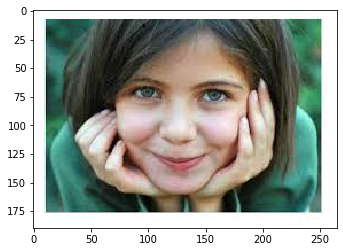

In [3]:
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = "Epoch 7.pth" #Pre-trained resnet50
model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resnet girişi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

test_im = Image.open("test.jpg")
plt.imshow(test_im)
test_im = train_transforms(test_im)
test_im = test_im.unsqueeze(0) #dimension expansion for batch
print(torch.argmax(model(test_im)).item())
#{'Eye Closed': 0, 'Neutral': 1, 'Shocked': 2, 'Smile': 3, 'Sunglass': 4}

### Real Time Detecting

###### Çıktılar için olasılıksal gösterim yapamıyorum. Çünkü pre-trained torch modeller sadece crossentropy loss kullanabiliyor => logaritmik softmax
Face Detection Model: haarcascade_frontalface_default

In [ ]:
import numpy as np
import cv2
import cvlib as cv
import sys
from PIL import Image
import numpy as np



#LOAD CLASSIFIER*********************
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()
#*************************************


filepath = "Epoch 7.pth" #Pre-trained resnet50
model = load_checkpoint(filepath)




extra_pixel = 150

#Parameters for Texts
font_scala=0.6
renk=(0,0,255)
font_tip=cv2.FONT_HERSHEY_SIMPLEX

#Save Video
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('real-time-detecting.avi',fourcc, 20.0, (640,480))

#Activate Capturing
cap = cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1000)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    #out.write(frame)
    
    
    #Detect Faces
    faces, confidences = cv.detect_face(frame)
    
    
    if(len(faces)!=0): #If the face is detected.
        
        #cv2.putText(frame,"Face is detected.",(25,40),font_tip,font_scala,renk)
    
        for face in faces:
            (startX,startY) = face[0],face[1]
            (endX,endY) = face[2],face[3]
            current_face = frame[startX-extra_pixel:endX+extra_pixel,startY-extra_pixel:endY+extra_pixel]
            
            pil_image = Image.fromarray(current_face, mode = "RGB")#numpy to pil image because of torch model
            pil_image = train_transforms(pil_image)
            image = pil_image.unsqueeze(0)
            
            with torch.no_grad():
                result = model(image)
            
            
            if torch.argmax(result).item() == 0:
                cv2.putText(frame,"Eye Closed",(350,40),font_tip,font_scala,renk)
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)              
            if torch.argmax(result).item() == 1:
                cv2.putText(frame,"Neutral",(350,40),font_tip,font_scala,renk)
                cv2.rectangle(frame, (startX,startY), (endX,endY), (255,0,0), 2)               
            if torch.argmax(result).item() == 2:
                cv2.putText(frame,"Shocked",(350,40),font_tip,font_scala,renk)
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)        
            if torch.argmax(result).item() == 3:
                cv2.putText(frame,"Smile",(350,40),font_tip,font_scala,renk)
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,100,0), 2)
            if torch.argmax(result).item() == 4:
                cv2.putText(frame,"Sunglass",(350,40),font_tip,font_scala,renk)
                cv2.rectangle(frame, (startX,startY), (endX,endY), (100,0,0), 2)      
            
            
            out.write(frame)
    
    else: # If there is no face.    
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
        #cv2.putText(frame,"There is no face.",(25,40),font_tip,font_scala,renk)
    
    
    cv2.imshow('Facial Expressions', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()